# Reinforcement Learning for Lux AI Season 2 🤖

Part 2 of the RL series will now dig into building a working RL agent for the Lux AI Challenge, Season 2!

Lux AI is designed to be intuitive to understand, but heavily layered in complexity and interactions of game mechanics in an multi-agent cooperative and competitive environment. 

Lux AI Season 2's rules can be found here: https://www.lux-ai.org/specs-s2. Make sure to read them to learn how to the game works, and the rest of this tutorial will be much easier to understand.

Part 1 of the series covered the single-agent RL setup, but Lux AI Season 2 is multi-agent! Moreover, the environment has different phases and a complex action space which makes it difficult to learn or use of the box. 

This tutorial will cover simple tools and tricks on how to reduce a complex problem into a easier one! We will primarily focus on three things: 

1. Simplifying the action space with controllers/action wrappers
2. Simplifying observations
3. Transforming the three phase Lux AI game into a single phase game

This starter kit is also implemented in https://github.com/Lux-AI-Challenge/Lux-Design-S2/tree/main/kits/rl/sb3


## 1. Simplifying the Action Space

The action space is quite complicated in Lux S2 as each robot can move, dig, transfer/pickup, all in addition to being able to combine any sequence of these primitives into an action queue of up to length 20. For machine learning, such a massive action space leads to the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality), making any ML algorithm have a much harder time to learn something useful, especially in RL.

To handle this, we can program a custom Controller that translates actions from one action space to the original action space and adds a few tricks and heuristics to be integrated with RL training. Since the original lux action space is large, this controller can be a little complicated. For those who want to dive straight into training you can use the controller as is. 

For a high-level overview this controller will
- Define a massively simplified action space
- Translate actions from the discrete action space into the Lux S2 action space `action_to_lux_action`
- Add a heuristic factory action to build one Heavy robot
- Generate action masks where False = an action is invalid

Overall, the action space of the controller is a discrete action space with just 12 dimensions to control just one heavy robot. It allows for a robot's 4 directional movement, transferring ice in 4 directions in addition to center, picking up power, digging, and a no-op action. This doesn't include factory actions, self destruct, recharging, transferring other types of resources, or longer planned action queues in the action space, which are all open problems for you to potentially tackle!

The controller also includes a trick to allow agents to reduce power costs incurred by action queue updates. The controller skips updating action queues if the existing action queue is the same as the new one the agent wants to use for the robot.

While this simplification doesn't include adding in more complex things like more heavy robots or planting lichen, it will train out a succesful policy that with simple modifications, will beat the majority of bots using the rule-based starter kits.

More advanced usages can consider how to model the actions of different types of units on a game board (e.g. heavy, light, or factory) by using a MultiDiscrete action space. A more practical and likely winning solution can be to use a image-like controller by generating actions for each tile on the board and only using the actions with friendly units on that tile. See [Season 1's solution by ToadBrigade](https://www.kaggle.com/competitions/lux-ai-2021/discussion/294993) and our previous [research paper: Emergent Collective Intelligence from Massive-Agent Cooperation and Competition](https://arxiv.org/abs/2301.01609) for how a image-like controller can work.


In [7]:
from typing import Dict, Any

import numpy as np
import numpy.typing as npt
from gym import spaces
import sys

class Controller:
    def __init__(self, action_space: spaces.Space) -> None:
        self.action_space = action_space

    def action_to_lux_action(
        self, agent: str, obs: Dict[str, Any], action: npt.NDArray
    ):
        """
        Takes as input the current "raw observation" and the parameterized action and returns
        an action formatted for the Lux env
        """
        raise NotImplementedError()
    def action_masks(self, agent: str, obs: Dict[str, Any]):
        """
        Generates a boolean action mask indicating in each discrete dimension whether it would be valid or not
        """
        raise NotImplementedError()
    
class SimpleUnitDiscreteController(Controller):
    def __init__(self, env_cfg) -> None:
        """
        A simple controller that controls only the robot that will get spawned. 
        Moreover, it will always try to spawn one heavy robot if there are none regardless of action given

        For the robot unit
        - 4 cardinal direction movement (4 dims)
        - a move center no-op action (1 dim)
        - transfer action just for transferring ice in 4 cardinal directions or center (5)
        - pickup action for power (1 dims)
        - dig action (1 dim)
        - no op action (1 dim) - equivalent to not submitting an action queue which costs power

        It does not include
        - self destruct action
        - recharge action
        - planning (via actions executing multiple times or repeating actions)
        - factory actions
        - transferring power or resources other than ice

        To help understand how to this controller works to map one action space to the original lux action space,
        see how the lux action space is defined in luxai_s2/spaces/action.py

        """
        self.env_cfg = env_cfg
        self.move_act_dims = 4
        self.transfer_act_dims = 5
        self.pickup_act_dims = 1
        self.dig_act_dims = 1
        self.no_op_dims = 1


        self.move_dim_high = self.move_act_dims
        self.transfer_dim_high = self.move_dim_high + self.transfer_act_dims
        self.pickup_dim_high = self.transfer_dim_high + self.pickup_act_dims
        self.dig_dim_high = self.pickup_dim_high + self.dig_act_dims
        self.no_op_dim_high = self.dig_dim_high + self.no_op_dims

        self.total_act_dims = self.no_op_dim_high
        action_space = spaces.Discrete(self.total_act_dims)
        super().__init__(action_space)

    def _is_move_action(self, id):
        return id < self.move_dim_high

    def _get_move_action(self, id):
        # move direction is id + 1 since we don't allow move center here
        return np.array([0, id + 1, 0, 0, 0, 1])

    def _is_transfer_action(self, id):
        return id < self.transfer_dim_high

    def _get_transfer_action(self, id):
        id = id - self.move_dim_high
        transfer_dir = id % 5
        return np.array([1, transfer_dir, 0, self.env_cfg.max_transfer_amount, 0, 1])

    def _is_pickup_action(self, id):
        return id < self.pickup_dim_high

    def _get_pickup_action(self, id):
        return np.array([2, 0, 4, self.env_cfg.max_transfer_amount, 0, 1])

    def _is_dig_action(self, id):
        return id < self.dig_dim_high

    def _get_dig_action(self, id):
        return np.array([3, 0, 0, 0, 0, 1])

    def action_to_lux_action(
        self, agent: str, obs: Dict[str, Any], action: npt.NDArray
    ):
        shared_obs = obs["player_0"]
        lux_action = dict()
        units = shared_obs["units"][agent]
        for unit_id in units.keys():
            unit = units[unit_id]
            choice = action
            action_queue = []
            no_op = False
            if self._is_move_action(choice):
                action_queue = [self._get_move_action(choice)]
            elif self._is_transfer_action(choice):
                action_queue = [self._get_transfer_action(choice)]
            elif self._is_pickup_action(choice):
                action_queue = [self._get_pickup_action(choice)]
            elif self._is_dig_action(choice):
                action_queue = [self._get_dig_action(choice)]
            else:
                # action is a no_op, so we don't update the action queue
                no_op = True
            
            # simple trick to help agents conserve power is to avoid updating the action queue
            # if the agent was previously trying to do that particular action already
            if len(unit["action_queue"]) > 0 and len(action_queue) > 0:
                same_actions = (unit["action_queue"][0] == action_queue[0]).all()
                if same_actions:
                    no_op = True
            if not no_op: lux_action[unit_id] = action_queue
            
            break

        factories = shared_obs["factories"][agent]
        if len(units) == 0:
            for unit_id in factories.keys():
                lux_action[unit_id] = 1  # build a single heavy

        return lux_action

    def action_masks(self, agent: str, obs: Dict[str, Any]):
        """
        Defines a simplified action mask for this controller's action space
        
        Doesn't account for whether robot has enough power
        """
        
        # compute a factory occupancy map that will be useful for checking if a board tile
        # has a factory and which team's factory it is.
        shared_obs = obs[agent]
        factory_occupancy_map = np.ones_like(shared_obs["board"]["rubble"], dtype=int) * -1
        factories = dict()
        for player in shared_obs["factories"]:
            factories[player] = dict()
            for unit_id in shared_obs["factories"][player]:
                f_data = shared_obs["factories"][player][unit_id]
                f_pos = f_data["pos"]
                # store in a 3x3 space around the factory position it's strain id.
                factory_occupancy_map[f_pos[0] - 1: f_pos[0] + 2, f_pos[1] - 1: f_pos[1] + 2] = f_data["strain_id"]


        units = shared_obs["units"][agent]
        action_masks = []
        for unit_id in units.keys():
            action_mask = np.zeros(self.total_act_dims)
            # movement is always valid
            action_mask[:4] = True

            # transferring is valid only if the target exists
            unit = units[unit_id]
            pos = np.array(unit["pos"])
            # a[1] = direction (0 = center, 1 = up, 2 = right, 3 = down, 4 = left)
            move_deltas = np.array([[0, 0], [0, -1], [1, 0], [0, 1], [-1, 0]])
            for i, move_delta in enumerate(move_deltas):
                transfer_pos = np.array([pos[0] + move_delta[0], pos[1] + move_delta[1]])
                # check if theres a factory tile there
                if transfer_pos[0] < 0 or transfer_pos[1] < 0 or transfer_pos[0] >= len(factory_occupancy_map) or transfer_pos[1] >= len(factory_occupancy_map[0]): continue
                factory_there = factory_occupancy_map[transfer_pos[0], transfer_pos[1]]
                if factory_there in shared_obs["teams"][agent]["factory_strains"]:
                    action_mask[self.transfer_dim_high - self.transfer_act_dims + i] = True

            factory_there = factory_occupancy_map[pos[0], pos[1]]
            on_top_of_factory = factory_there in shared_obs["teams"][agent]["factory_strains"]

            # dig is valid only if on top of tile with rubble or resources or lichen
            board_sum = shared_obs["board"]["ice"][pos[0], pos[1]] + shared_obs["board"]["ore"][pos[0], pos[1]] + shared_obs["board"]["rubble"][pos[0], pos[1]] + shared_obs["board"]["lichen"][pos[0], pos[1]]
            if board_sum > 0 and not on_top_of_factory:
                action_mask[self.dig_dim_high - self.dig_act_dims: self.dig_dim_high] = True
            
            # pickup is valid only if on top of factory tile
            if on_top_of_factory:
                action_mask[self.pickup_dim_high - self.pickup_act_dims: self.pickup_dim_high] = True
                action_mask[self.dig_dim_high - self.dig_act_dims: self.dig_dim_high] = False

            
            # no-op is always valid
            action_mask[-1] = True

            action_masks.append(action_mask)
            break
        action_masks = np.concatenate(action_masks, axis=-1)
        return action_masks

## 2. Simplifying the Observation Space

Lux S2 is fully observable which means you can see everything on the map, the opponents units etc. However, this is very high dimensional and not necessarily easy to learn from due to the curse of dimensionality (again!). We want to simplify this observation space in a way that contains sufficient information to learn a good policy but is also easy to learn from.

For this tutorial, we will create a state-based observation space (no image like features e.g. the rubble, ice, ore maps) with some feature engineering that includes useful information such as the distance to the closest factory and ice tile. The wrapper we provide below will use the `gym.ObservationWrapper` interface. Note that since we are focusing on just controlling one heavy robot, the observation wrapper is written to only support one heavy robot (and returns 0 if there are none).


More advanced solutions can look into using the full set of observations and designing the appropriate neural net architecture to process them. One idea would be to use convolutional neural networks to process board features like images. See [Season 1's solution by ToadBrigade](https://www.kaggle.com/competitions/lux-ai-2021/discussion/294993) and our previous [research paper: Emergent Collective Intelligence from Massive-Agent Cooperation and Competition](https://arxiv.org/abs/2301.01609) for example architectures and feature engineering choices.


In [2]:
from typing import Dict, Any

import gym
import numpy as np
import numpy.typing as npt
from gym import spaces

class SimpleUnitObservationWrapper(gym.ObservationWrapper):
    """
    A simple state based observation to work with in pair with the SimpleUnitDiscreteController

    It contains info only on the first robot, the first factory you own, and some useful features. If there are no owned robots the observation is just zero.
    No information about the opponent is included. This will generate observations for all teams.

    Included features:
    - First robot's stats
    - distance vector to closest ice tile
    - distance vector to first factory

    """

    def __init__(self, env: gym.Env) -> None:
        super().__init__(env)
        self.observation_space = spaces.Box(-999, 999, shape=(13,))

    def observation(self, obs):
        return SimpleUnitObservationWrapper.convert_obs(obs, self.env.state.env_cfg)

    # we make this method static so the submission/evaluation code can use this as well
    @staticmethod
    def convert_obs(
        obs: Dict[str, Any], env_cfg: Any
    ) -> Dict[str, npt.NDArray]:
        observation = dict()
        shared_obs = obs["player_0"]
        ice_map = shared_obs["board"]["ice"]
        ice_tile_locations = np.argwhere(ice_map == 1)

        for agent in obs.keys():
            obs_vec = np.zeros(13, )

            factories = shared_obs["factories"][agent]
            factory_vec = np.zeros(2)
            for k in factories.keys():
                # here we track a normalized position of the first friendly factory
                factory = factories[k]
                factory_vec = np.array(factory["pos"]) / env_cfg.map_size
                break
            units = shared_obs["units"][agent]
            for k in units.keys():
                unit = units[k]

                # store cargo+power values scaled to [0, 1]
                cargo_space = env_cfg.ROBOTS[
                    unit["unit_type"]
                ].CARGO_SPACE
                battery_cap = env_cfg.ROBOTS[
                    unit["unit_type"]
                ].BATTERY_CAPACITY
                cargo_vec = np.array(
                    [
                        unit["power"] / battery_cap,
                        unit["cargo"]["ice"] / cargo_space,
                        unit["cargo"]["ore"] / cargo_space,
                        unit["cargo"]["water"] / cargo_space,
                        unit["cargo"]["metal"] / cargo_space,
                    ]
                )
                unit_type = (
                    0 if unit["unit_type"] == "LIGHT" else 1
                )  # note that build actions use 0 to encode Light
                # normalize the unit position
                pos = np.array(unit["pos"]) / env_cfg.map_size
                unit_vec = np.concatenate(
                    [pos, [unit_type], cargo_vec, [unit["team_id"]]], axis=-1
                )
                
                # we add some engineered features down here 
                # compute closest ice tile
                ice_tile_distances = np.mean(
                    (ice_tile_locations - np.array(unit["pos"])) ** 2, 1
                )
                # normalize the ice tile location
                closest_ice_tile = (
                    ice_tile_locations[np.argmin(ice_tile_distances)]
                    / env_cfg.map_size
                )
                obs_vec = np.concatenate(
                    [unit_vec, factory_vec - pos, closest_ice_tile - pos], axis=-1
                )
                break
            observation[agent] = obs_vec

        return observation

## 3. Transforming Lux S2 into a Single Phase

Normally RL frameworks like Stable Baselines 3, RLlib, Tianshou etc. expect the action space and observation space to be consistent throughout an episode. Lux S2 does not conform to this as we add some additional complexity like bidding and factory placement phases. A simple way to get around this is to **upgrade the reset function.**

Previously we saw that `env.reset()` resets an environment to a clean slate. We will upgrade this function by building a environment wrapper that not only resets to the clean slate, but also handles the bidding and factory placement phases so effectively agents that are learning start from game states with factories already placed.

Below will build a wrapper that works with the SB3 package. To do this, we want to provide the wrapper a bidding policy and factory placement policy which will be used by all teams to handle the first two phases in the reset function. The code below does just that by overriding the environment's reset function in the wrapper. 

Furthermore, we want to use the Controller we defined earlier, so that is also an argument to the SB3Wrapper and we use it to transform actions inside the `env.step` function

In [2]:
from typing import Callable, Dict

import gym
import numpy as np
import numpy.typing as npt
from gym import spaces

import luxai_s2.env
from luxai_s2.env import LuxAI_S2
from luxai_s2.state import ObservationStateDict
from luxai_s2.unit import ActionType, BidActionType, FactoryPlacementActionType
from luxai_s2.utils import my_turn_to_place_factory
from luxai_s2.wrappers.controllers import (
    Controller,
)


class SB3Wrapper(gym.Wrapper):
    def __init__(
        self,
        env: LuxAI_S2,
        bid_policy: Callable[
            [str, ObservationStateDict], Dict[str, BidActionType]
        ] = None,
        factory_placement_policy: Callable[
            [str, ObservationStateDict], Dict[str, FactoryPlacementActionType]
        ] = None,
        controller: Controller = None,
    ) -> None:
        """
        A environment wrapper for Stable Baselines 3. It reduces the LuxAI_S2 env
        into a single phase game and places the first two phases (bidding and factory placement) into the env.reset function so that
        interacting agents directly start generating actions to play the third phase of the game.

        It also accepts a Controller that translates action's in one action space to a Lux S2 compatible action

        Parameters
        ----------
        bid_policy: Function
            A function accepting player: str and obs: ObservationStateDict as input that returns a bid action
            such as dict(bid=10, faction="AlphaStrike"). By default will bid 0
        factory_placement_policy: Function
            A function accepting player: str and obs: ObservationStateDict as input that returns a factory placement action
            such as dict(spawn=np.array([2, 4]), metal=150, water=150). By default will spawn in a random valid location with metal=150, water=150
        controller : Controller
            A controller that parameterizes the action space into something more usable and converts parameterized actions to lux actions.
            See luxai_s2/wrappers/controllers.py for available controllers and how to make your own
        """
        gym.Wrapper.__init__(self, env)
        self.env = env
        
        assert controller is not None
        
        # set our controller and replace the action space
        self.controller = controller
        self.action_space = controller.action_space

        # The simplified wrapper removes the first two phases of the game by using predefined policies (trained or heuristic)
        # to handle those two phases during each reset
        if factory_placement_policy is None:
            def factory_placement_policy(player, obs: ObservationStateDict):
                potential_spawns = np.array(
                    list(zip(*np.where(obs["board"]["valid_spawns_mask"] == 1)))
                )
                spawn_loc = potential_spawns[
                    np.random.randint(0, len(potential_spawns))
                ]
                return dict(spawn=spawn_loc, metal=150, water=150)

        self.factory_placement_policy = factory_placement_policy
        if bid_policy is None:
            def bid_policy(player, obs: ObservationStateDict):
                faction = "AlphaStrike"
                if player == "player_1":
                    faction = "MotherMars"
                return dict(bid=0, faction=faction)

        self.bid_policy = bid_policy

        self.prev_obs = None

    def step(self, action: Dict[str, npt.NDArray]):
        
        # here, for each agent in the game we translate their action into a Lux S2 action
        lux_action = dict()
        for agent in self.env.agents:
            if agent in action:
                lux_action[agent] = self.controller.action_to_lux_action(
                    agent=agent, obs=self.prev_obs, action=action[agent]
                )
            else:
                lux_action[agent] = dict()
        
        # lux_action is now a dict mapping agent name to an action
        obs, reward, done, info = self.env.step(lux_action)
        self.prev_obs = obs
        return obs, reward, done, info

    def reset(self, **kwargs):
        # we upgrade the reset function here
        
        # we call the original reset function first
        obs = self.env.reset(**kwargs)
        
        # then use the bid policy to go through the bidding phase
        action = dict()
        for agent in self.env.agents:
            action[agent] = self.bid_policy(agent, obs[agent])
        obs, _, _, _ = self.env.step(action)
        
        # while real_env_steps < 0, we are in the factory placement phase
        # so we use the factory placement policy to step through this
        while self.env.state.real_env_steps < 0:
            action = dict()
            for agent in self.env.agents:
                if my_turn_to_place_factory(
                    obs["player_0"]["teams"][agent]["place_first"],
                    self.env.state.env_steps,
                ):
                    action[agent] = self.factory_placement_policy(agent, obs[agent])
                else:
                    action[agent] = dict()
            obs, _, _, _ = self.env.step(action)
        self.prev_obs = obs
        
        return obs


To test the code above, we can program some heuristic bid and factory placement policies

In [3]:
def zero_bid(player, obs: ObservationStateDict) -> BidActionType:
    # a policy that always bids 0
    faction = "AlphaStrike"
    if player == "player_1":
        faction = "MotherMars"
    return dict(bid=0, faction=faction)

def random_factory_placement(player, obs: ObservationStateDict) -> FactoryPlacementActionType:
    """
    This policy places factories with 150 water and metal at random locations
    """
    # we will spawn our factory in a random location with 150 metal and water if it is our turn to place
    potential_spawns = np.array(list(zip(*np.where(obs["board"]["valid_spawns_mask"] == 1))))
    spawn_loc = potential_spawns[np.random.randint(0, len(potential_spawns))]
    return dict(spawn=spawn_loc, metal=150, water=150)

So **without the wrapper**, when we reset the environment it looks like this:

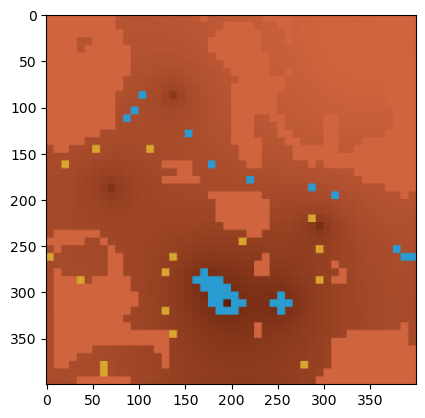

In [4]:
import matplotlib.pyplot as plt
env = gym.make("LuxAI_S2-v0")
env.reset(seed=0)
img = env.render("rgb_array")
plt.imshow(img)

**With the wrapper**, when we reset the environment it looks like this:

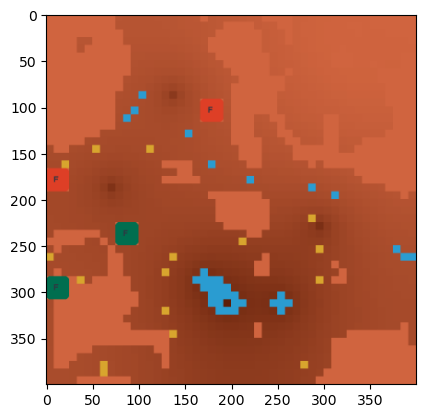

In [8]:
import matplotlib.pyplot as plt
env = gym.make("LuxAI_S2-v0")
env = SB3Wrapper(env, zero_bid, random_factory_placement, controller=SimpleUnitDiscreteController(env.env_cfg))
env.reset(seed=0)
img = env.render("rgb_array")
plt.imshow(img)

Success! Our upgraded reset function makes the environment now start from the start of the normal game phase, meaning the action space can be consistently the same throughout the game.

## 4. Training

In the previous tutorial, we saw how to train an agent with SB3 in single-agent environments. Handling true multi-agent via training separate or shared policies to control all agents requires a few extra things so instead, for the purpose of a tutorial we will treat Lux S2 like a single agent environment by training a policy for one team and letting the other team simply do nothing.

Moreover, we want to define our own reward function to encourage our robots to seek ice, dig it, and return to a factory so it can generate water and survive longer. To do this all, we will just create a custom environment wrapper.




## Multi-agent to Single-agent

Multi-agent environments are effectively multiple singular agents put together in the same environment at the same time. In typical multi-agent RL, you may often want to train a policy that plays all the controllable agents, not just one, which gathers more replay data and enables self-play. Self-play is a future topic to be discussed but shows potential to autonomously train a policy against itself and lead to learning stronger and stronger behaviors and potentially even emergent ones.

For the sake of a tutorial, we will treat Lux as a single-agent environment. Naturally, a way to reduce the problem is to simply control only one of the agents in the game and let the other agent be a agent that does nothing or a heuristic of some kind to train against.